# Introduction: Dynamical systems and their attractors

This notebook is separated into two blocks: the first is an introduction to DynamicalSystems.jl. The second is a deeper dive into one of its submodules, Attractors.jl.

**Versions:** Please ensure you have the following packages installed, with these versions or newer:

In [1]:
import Pkg
Pkg.status(["DynamicalSystems", "Attractors", "CairoMakie"])

Status `C:\Users\gd419\.julia\environments\v1.8\Project.toml`


  [f3fd9213] Attractors v1.1.1 `C:\Users\gd419\.julia\dev\Attractors`
  [13f3f980] CairoMakie v0.10.2
  [61744808] DynamicalSystems v3.0.0 `C:\Users\gd419\.julia\dev\DynamicalSystems`


Quick theme change for plotting in zoomed-in Jupyter notebooks:

In [2]:
using CairoMakie
update_theme!(resolution = (500, 300), fontsize = 16)

# DynamicalSystems.jl

**DynamicalSystems.jl** is an [award-winning](https://dsweb.siam.org/The-Magazine/Article/winners-of-the-dsweb-2018-software-contest) Julia software library for nonlinear dynamics and nonlinear timeseries analysis. It is composed of several submodules/subpackages, most of which are exposed in higher detail throughout this course series.

The list of contents of **DynamicalSystems.jl** is rather larger and is best seen [online](https://juliadynamics.github.io/DynamicalSystems.jl/latest/contents/).

The section that follows is a verbatim copy of the online [overarching tutorial for **DynamicalSystems.jl**](https://juliadynamics.github.io/DynamicalSystems.jl/latest/tutorial/). It has two goals: 

1. To teach you "the ropes" of DynamicalSystems.jl in about 20 minutes.
2. To give you an idea of all the subpackages that go into DynamicalSystems.jl. This can be a bit overwhelming depending on your familiarity with nonlinear dynamics, but do not worry if this is so. Followup tutorials go in more depth, and explain in greater length, the subpackages.


## Core components

The individual packages that compose `DynamicalSystems` interact flawlessly with each other because of the following two components:

1. The `StateSpaceSet`, which represents numerical data. They can be observed or measured from experiments, sampled trajectories of dynamical systems, or just unordered sets in a state space. A `StateSpaceSet` is a container of equally-sized points, representing multivariate timeseries or multivariate datasets. Timeseries, which are univariate sets, are represented by the `AbstractVector{<:Real}` Julia base type.
2. The `DynamicalSystem`, which is the abstract representation of a dynamical system with a known dynamic evolution rule. `DynamicalSystem` defines an extendable interface, but typically one uses concrete implementations such as `DeterministicIteratedMap` or `CoupledODEs`.



## Making dynamical systems

In the majority of cases, to make a dynamical system one needs three things:

1. The dynamic rule `f`: A Julia function that provides the instructions of how to evolve the dynamical system in time.
2. The state `u`: An array-like container that contains the variables of the dynamical system and also defines the starting state of the system.
3. The parameters `p`: An arbitrary container that parameterizes `f`.

For most concrete implementations of `DynamicalSystem` there are two ways of defining `f, u`.
The distinction is done on whether `f` is defined as an in-place (iip) function or out-of-place (oop) function.

* **oop** : `f` **must** be in the form `f(u, p, t) -> out`
    which means that given a state `u::SVector{<:Real}` and some parameter container
    `p` it returns the output of `f` as an `SVector{<:Real}` (static vector).
* **iip** : `f` **must** be in the form `f!(out, u, p, t)`
    which means that given a state `u::AbstractArray{<:Real}` and some parameter container `p`,
    it writes in-place the output of `f` in `out::AbstractArray{<:Real}`.
    The function **must** return `nothing` as a final statement.

`t` stands for current time in both cases.
**iip** is suggested for systems with high dimension and **oop** for small.
The break-even point is between 10 to 100 dimensions but should be benchmarked
on a case-by-case basis as it depends on the complexity of `f`.

### Example: Henon map
Let's make the Henon map, defined as
$$
\begin{aligned}
x_{n+1} &= 1 - ax^2_n+y_n \\
y_{n+1} & = bx_n
\end{aligned}
$$
with parameters $a = 1.4, b = 0.3$.

First, we define the dynamic rule as a standard Julia function. Since the dynamical system is only two-dimensional, we should use the _out-of-place_ form that returns an `SVector` with the next state:


In [5]:
using DynamicalSystems

function henon_rule(u, p, n) # here `n` is "time", but we don't use it.
    x, y = u # system state
    a, b = p # system parameters
    xn = 1.0 - a*x^2 + y
    yn = b*x
    return SVector(xn, yn)
end

henon_rule (generic function with 1 method)

Then, we define initial state and parameters

In [6]:
u0 = [0.2, 0.3]
p0 = [1.4, 0.3]

2-element Vector{Float64}:
 1.4
 0.3

Lastly, we give these three to the `DeterministicIteratedMap`:

In [7]:
henon = DeterministicIteratedMap(henon_rule, u0, p0)

2-dimensional DeterministicIteratedMap
 deterministic: true
 discrete time: true
 in-place:      false
 dynamic rule:  henon_rule
 parameters:    [1.4, 0.3]
 time:          0
 state:         [0.2, 0.3]


`henon` is a `DynamicalSystem`, one of the two core structures of the library.
`DynamicalSystem`s can evolved interactively, and queried, using the interface defined by `DynamicalSystem` (which will be exposed in a more advanced tutorial). The simplest thing you can do with a `DynamicalSystem` is to get its trajectory:

In [8]:
total_time = 10_000
X, t = trajectory(henon, total_time)

(2-dimensional StateSpaceSet{Float64} with 10001 points, 0:1:10000)

In [9]:
X

2-dimensional StateSpaceSet{Float64} with 10001 points
  0.2        0.3
  1.244      0.06
 -1.10655    0.3732
 -0.341035  -0.331965
  0.505208  -0.102311
  0.540361   0.151562
  0.742777   0.162108
  0.389703   0.222833
  1.01022    0.116911
 -0.311842   0.303065
  ⋮         
 -0.582534   0.328346
  0.853262  -0.17476
 -0.194038   0.255978
  1.20327   -0.0582113
 -1.08521    0.36098
 -0.287758  -0.325562
  0.558512  -0.0863275
  0.476963   0.167554
  0.849062   0.143089

`X` is a `StateSpaceSet`, the second of the core structures of the library. We'll see below how, and where, to use a `StateSpaceset`, but for now let's just do a scatter plot

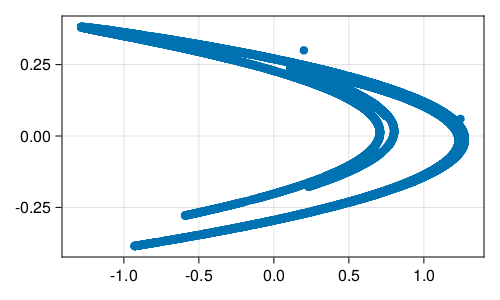

In [10]:
using CairoMakie
scatter(X[:, 1], X[:, 2])


### Example: Lorenz96

Let's also make another dynamical system, the Lorenz96 model:
$$
\frac{dx_i}{dt} = (x_{i+1}-x_{i-2})x_{i-1} - x_i + F
$$
for $i \in \{1, \ldots, N\}$ and $N+j=j$.

Here, instead of a discrete time map we have $N$ coupled ordinary differential equations. However, creating the dynamical system works out just like above, but using `CoupledODEs` instead of `DeterministicIteratedMap`.

First, we make the dynamic rule function. Since this dynamical system can be arbitrarily high-dimensional, we prefer to use the _in-place_ form for `f`, overwriting in place the rate of change in a pre-allocated container.

In [11]:
function lorenz96_rule!(du, u, p, t)
    F = p[1]; N = length(u)
    # 3 edge cases
    du[1] = (u[2] - u[N - 1]) * u[N] - u[1] + F
    du[2] = (u[3] - u[N]) * u[1] - u[2] + F
    du[N] = (u[1] - u[N - 2]) * u[N - 1] - u[N] + F
    # then the general case
    for n in 3:(N - 1)
        du[n] = (u[n + 1] - u[n - 2]) * u[n - 1] - u[n] + F
    end
    return nothing # always `return nothing` for in-place form!
end

lorenz96_rule! (generic function with 1 method)

then, like before, we define an initial state and parameters, and initialize the system

In [13]:
N = 6
u0 = range(0.1, 1; length = N)
p0 = [8.0]
lorenz96 = CoupledODEs(lorenz96_rule!, u0, p0)

6-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      true
 dynamic rule:  lorenz96_rule!
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [8.0]
 time:          0.0
 state:         [0.1, 0.28, 0.46, 0.64, 0.82, 1.0]


and, again like before, we may obtain a trajectory the same way


In [14]:
total_time = 12.5
sampling_time = 0.02
Y, t = trajectory(lorenz96, total_time; Ttr = 2.2, Δt = sampling_time)
Y

6-dimensional StateSpaceSet{Float64} with 626 points
  3.15368   -4.40493  0.0311581  0.486735  1.89895   4.15167
  2.71382   -4.39303  0.395019   0.66327   2.0652    4.32045
  2.25088   -4.33682  0.693967   0.879701  2.2412    4.46619
  1.7707    -4.24045  0.924523   1.12771   2.42882   4.58259
  1.27983   -4.1073   1.08656    1.39809   2.62943   4.66318
  0.785433  -3.94005  1.18319    1.6815    2.84384   4.70147
  0.295361  -3.74095  1.2205     1.96908   3.07224   4.69114
 -0.181932  -3.51222  1.20719    2.25296   3.3139    4.62628
 -0.637491  -3.25665  1.154      2.5267    3.56698   4.50178
 -1.06206   -2.9781   1.07303    2.7856    3.82827   4.31366
  ⋮                                                  ⋮
  3.17245    2.3759   3.01796    7.27415   7.26007  -0.116002
  3.29671    2.71146  3.32758    7.5693    6.75971  -0.537853
  3.44096    3.09855  3.66908    7.82351   6.13876  -0.922775
  3.58387    3.53999  4.04452    8.01418   5.39898  -1.25074
  3.70359    4.03513  4.45448    8.

We can't scatterplot something 6-dimensional but we can visualize all timeseries


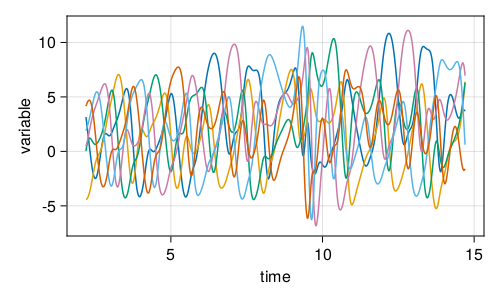

In [15]:
fig = Figure()
ax = Axis(fig[1,1]; xlabel = "time", ylabel = "variable")
for var in columns(Y)
    lines!(ax, t, var)
end
fig


### ODE solving

Continuous time dynamical systems are evolved through DifferentialEquations.jl.
When initializing a `CoupledODEs` you can tune the solver properties to your heart's content using any of the [ODE solvers](https://diffeq.sciml.ai/latest/solvers/ode_solve/) and any of the [common solver options](https://diffeq.sciml.ai/latest/basics/common_solver_opts/). For example:


In [17]:
using OrdinaryDiffEq # accessing the ODE solvers
asdf = (alg = Vern9(), abstol = 1e-9, reltol = 1e-9)
lorenz96_vern = CoupledODEs(lorenz96_rule!, u0, p0; diffeq = asdf)

6-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      true
 dynamic rule:  lorenz96_rule!
 ODE solver:    Vern9
 ODE kwargs:    (abstol = 1.0e-9, reltol = 1.0e-9)
 parameters:    [8.0]
 time:          0.0
 state:         [0.1, 0.28, 0.46, 0.64, 0.82, 1.0]


In [18]:
Y, t = trajectory(lorenz96_vern, total_time; Ttr = 2.2, Δt = sampling_time)
Y[end]

6-element SVector{6, Float64} with indices SOneTo(6):
  3.8390248122550252
  6.1557095311542325
  6.080625689025621
  7.278588308988913
  1.2582152212831657
 -1.5297062916833186

## State space sets


Let's recall that the output of the `trajectory` function is a `StateSpaceSet`:


In [19]:
X

2-dimensional StateSpaceSet{Float64} with 10001 points
  0.2        0.3
  1.244      0.06
 -1.10655    0.3732
 -0.341035  -0.331965
  0.505208  -0.102311
  0.540361   0.151562
  0.742777   0.162108
  0.389703   0.222833
  1.01022    0.116911
 -0.311842   0.303065
  ⋮         
 -0.582534   0.328346
  0.853262  -0.17476
 -0.194038   0.255978
  1.20327   -0.0582113
 -1.08521    0.36098
 -0.287758  -0.325562
  0.558512  -0.0863275
  0.476963   0.167554
  0.849062   0.143089

It is printed like a matrix where each column is the timeseries of each dynamic variable. In reality, it is a vector of statically sized vectors (for performance reasons). When indexed with 1 index, it behaves like a vector of vectors


In [20]:
X[1]

2-element SVector{2, Float64} with indices SOneTo(2):
 0.2
 0.3

In [21]:
X[2:5]

2-dimensional StateSpaceSet{Float64} with 4 points
  1.244      0.06
 -1.10655    0.3732
 -0.341035  -0.331965
  0.505208  -0.102311

When indexed with two indices, it behaves like a matrix


In [22]:
X[2:5, 2]

4-element Vector{Float64}:
  0.06
  0.3732
 -0.3319651199999999
 -0.10231059085086688

When iterated, it iterates over the contained points

In [23]:
for (i, point) in enumerate(X)
    @show point
    i > 5 && break
end

point = [0.2, 0.3]
point = [1.244, 0.06]
point = [-1.1065503999999997, 0.3732]
point = [-0.34103530283622296, -0.3319651199999999]
point = [0.5052077711071681, -0.10231059085086688]
point = [0.5403605603672313, 0.1515623313321504]


In [ ]:
map(point -> point[1] + point[2], X)

The columns of the set are obtained with the convenience `columns` function

In [24]:
x, y = columns(X)
summary.((x, y))

("10001-element Vector{Float64}", "10001-element Vector{Float64}")

## Using dynamical systems


You may use the `DynamicalSystem` interface to develop algorithms that utilize dynamical systems with a known evolution rule. The two main packages of the library that do this are `ChaosTools` and `Attractors`. For example, you may want to compute the Lyapunov spectrum of the Lorenz96 system from above. This is as easy as calling the `lyapunovspectrum` function with `lorenz96`

In [25]:
lorenz96

6-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      true
 dynamic rule:  lorenz96_rule!
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [8.0]
 time:          14.701155548166824
 state:         [3.687684968603637, 6.420665787459184, 6.335096579489903, 6.903265136403762, 0.5554899247911422, -1.5862759400464632]


In [26]:
steps = 10_000
lyapunovspectrum(lorenz96, steps)

6-element Vector{Float64}:
  0.9578297436475176
  0.0007190960153067711
 -0.1574913469515455
 -0.7575338861926553
 -1.4036253850303557
 -4.639894729260121

In [27]:
henon

2-dimensional DeterministicIteratedMap
 deterministic: true
 discrete time: true
 in-place:      false
 dynamic rule:  henon_rule
 parameters:    [1.4, 0.3]
 time:          10000
 state:         [0.8490622425588493, 0.14308891934161724]


In [28]:
lyapunovspectrum(henon, steps)

2-element Vector{Float64}:
  0.4167659070649148
 -1.6207387113908505

As expected, there is at least one positive Lyapunov exponent (before the system is chaotic) and at least one zero Lyapunov exponent, because the system is continuous time.


Alternatively, you may want to estimate the basins of attraction of a multistable dynamical system. The Henon map is "multistable" in the sense that some initial conditions diverge to infinity, and some others converge to a chaotic attractor. Computing these basins of attraction is simple with [`Attractors`](@ref), and would work as follows:

In [29]:
# define a state space grid to compute the basins on:
xg = yg = range(-2, 2; length = 201)
# find attractors using recurrences in state space:
grid = (xg, yg)
mapper = AttractorsViaRecurrences(henon, grid)
# compute the full basins of attraction over a given grid
basins, attractors = basins_of_attraction(mapper, grid; show_progress = false)

(Int32[-1 -1 … -1 -1; -1 -1 … -1 -1; … ; -1 -1 … -1 -1; -1 -1 … -1 -1], Dict{Int32, StateSpaceSet{2, Float64}}(1 => 2-dimensional StateSpaceSet{Float64} with 511 points))

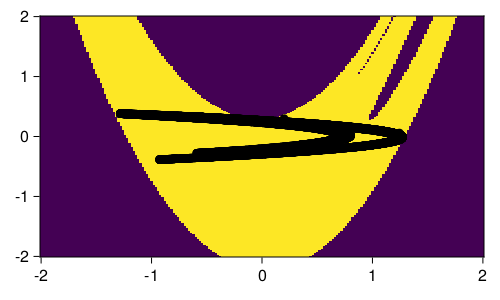

In [30]:
fig, ax = heatmap(xg, yg, basins)
x, y = columns(X) # attractor of Henon map
scatter!(ax, x, y; color = "black")
fig

## Using state space sets

Several packages of the library deal with `StateSpaceSets`.

You could use `ComplexityMeasures` to obtain the entropy, or other complexity measures, of a given set. Below, we obtain the entropy of the natural density of the chaotic attractor by partitioning into a histogram of approximately `50` bins per dimension:


In [31]:
X

2-dimensional StateSpaceSet{Float64} with 10001 points
  0.2        0.3
  1.244      0.06
 -1.10655    0.3732
 -0.341035  -0.331965
  0.505208  -0.102311
  0.540361   0.151562
  0.742777   0.162108
  0.389703   0.222833
  1.01022    0.116911
 -0.311842   0.303065
  ⋮         
 -0.582534   0.328346
  0.853262  -0.17476
 -0.194038   0.255978
  1.20327   -0.0582113
 -1.08521    0.36098
 -0.287758  -0.325562
  0.558512  -0.0863275
  0.476963   0.167554
  0.849062   0.143089

In [ ]:
prob_est = ValueHistogram(50)
entropy(prob_est, X)

Alternatively, you could use `FractalDimensions` to get the fractal dimensions of the chaotic attractor of the henon map using the Grassberger-Procaccia algorithm:


In [32]:
grassberger_proccacia_dim(X)

1.2222029831072245

Or, you could obtain a recurrence matrix of a state space set with `RecurrenceAnalysis`


In [ ]:
R = RecurrenceMatrix(Y, 8.0)
Rg = grayscale(R)
rr = recurrencerate(R)
heatmap(Rg; colormap = :grays,
    axis = (title = "recurrence rate = $(rr)", aspect = 1,)
)

## More nonlinear timeseries analysis


A `trajectory` of a known dynamical system is one way to obtain a `StateSpaceSet`. However, another common way is via a delay coordinates embedding of a measured/observed timeseries. For example, we could use `optimal_traditional_de` from `DelayEmbeddings` to create an optimized delay coordinates embedding of a timeseries


In [ ]:
w = Y[:, 1] # first variable of Lorenz96
𝒟, τ, e = optimal_traditional_de(w)
𝒟

and compare

In [ ]:
fig = Figure()
axs = [Axis3(fig[1,i]) for i in 1:2]
for (S, ax) in zip((Y, 𝒟), axs)
    lines!(ax, S[:, 1], S[:, 2], S[:, 3])
end
fig

Since `𝒟` is just another state space set, we could be using any of the above analysis pipelines on it just as easily.


The last package to mention here is `TimeseriesSurrogates`, which ties with all other observed/measured data analysis by providing a framework for confidence/hypothesis testing. For example, if we had a measured timeseries but we were not sure whether it represents a deterministic system with structure in the state space, or mostly noise, we could do a surrogate test. For this, we use `surrogenerator` and `RandomFourier` from `TimeseriesSurrogates`, and the `generalized_dim` from `FractalDimensions` (because it performs better in noisy sets)

In [ ]:
x = X[:, 1] # Henon map timeseries
# contaminate with noise
using Random: Xoshiro
rng = Xoshiro(1234)
x .+= randn(rng, length(x))/100
# compute noise-contaminated fractal dim.
Δ_orig = generalized_dim(embed(x, 2, 1))

And we do the surrogate test


In [ ]:
surrogate_method = RandomFourier()
sgen = surrogenerator(x, surrogate_method, rng)

Δ_surr = map(1:1000) do i
    s = sgen()
    generalized_dim(embed(s, 2, 1))
end

and visualize the test result


In [ ]:
fig, ax = hist(Δ_surr)
vlines!(ax, Δ_orig)
fig

since the real value is outside the distribution we have confidence the data are not pure noise.

# Exercises - DynamicalSystems.jl

## Timeseries of a multistable predator prey model

Consider the following (modified) form of the Rozenweig-MacArthur model for predator-prey dynamics:
$$

\begin{align}
\frac{dN}{dt} & = rN\left(1-\frac{c}{r}N\right)\left(\frac{N-\mu}{N+\nu}\right) - A \\
\frac{dP}{dt} & = \chi A - \delta P \\
A & = \frac{\alpha N P}{\beta + N} 
\end{align}
$$

with initial parameters `p = [1.7, 0.19, 0.03, 0.003, 800, 1.5, 0.004, 2.2] = r, c, μ, ν, α, β, χ, δ`. Use the following three initial conditions: 
```julia
u1 = [5, 0.016]
u2 = [5, 0.025]
u3 = [15, 0.012]
```
For each, plot a lines plot of the timeseries of the first variable of the system using the `trajectory` function. Then, use the `set_parameter!` function to change the first parameter of the system (r) from 1.7 to 2.5. Repeat the same plot at the new parameter in a new axis below the previous one. Has the time evolution of any of the initial conditions changed fundamentally?

## Second exercise

Define and simulate the Ikeda map
$$
\begin{aligned}
t &= c - \frac{d}{1 + x_n^2 + y_n^2} \\
x_{n+1} &= a + b(x_n \cos(t) - y_n\sin(t)) \\
y_{n+1} &= b(x_n\sin(t) + y_n \cos(t))
\end{aligned}
$$
with initial condition `u = ones(2)` and parameters `p = [a, b, c, d] = [6, 0.9, 3.1, 6]`. For these initial parameters the system generates an absolutely stunning attractor that has two seemingly separated components!

Scatterplot the attractor, and then calculate its fractal dimension, using either the `generalized_dim` or the `grassberger_proccacia_dim` functions.

Then manipulate the state space set containing the attractor so that you can generate two new state space sets: one with all points with x coordinate less than 2.5, and one with x more than 2.5. Compute the fractal dimension for the two subsets. Is any more "fractal" than the other?

# Attractors.jl

A Julia module for finding attractors of dynamical systems,
their basins and their boundaries, fractal properties of the boundaries,
as well as continuing attractors and their basins across parameters.

## Finding attractors and their fractions

The bulk of the work in Attractors.jl is done by the `AttractorMapper` supertype, that maps initial conditions to attractors. This allows one to calculate the fractions of the basins of attraction of each attractor. (or if computationally feasible the full basins)

The concrete subtypes that we'll cover here are:

1. `AttractorsViaRecurrences` 
2. `AttractorsViaFeaturizing`

Let's start with the recurrences version. It implements the algorithm described in [Datseris & Wagemakers (2022), _Effortless estimation of basins of attraction_](https://doi.org/10.1063/5.0076568). 

Basic knowledge of the algorithm is useful for deciding the keyword arguments of `AttractorsViaRecurrences`, however, explaining this algorithm is not part of the lecture! Worry not however, the exercises have been designed to work well with the default settings.

The only thing you need to know about the algorithm is the following: it uses recurrences in the state space to find the **actual** attractors of _any_ dynamical system. This is done by tessellating a finite region of the state space into finite-sized cells. Therefore, to initialize an `AttractorsViaRecurrences` we need two things:

1. A dynamical system instance
2. A grid that both decides the state space region of interest as well as defines its tesselation

We'll use this mapper to find attractors of the following dynamical system:
$$
\begin{aligned}
\dot{x} &= \sin(y) - bx\\
\dot{y} &= \sin(z) - by\\
\dot{z} &= \sin(x) - bz
\end{aligned}
$$
which, due to the symmetry of the equations of motion, any attractor has three symmetry versions (by cycling over the x, y, z coordinates). So this is a multistable dynamical system! 

For `b = 0.16` the system has three (symmetric) attracting limit cycles that can be found in the state space box spanning -3 to 3 in each dimension (we know this a-priori).

Let's define the dynamical system:

In [33]:
function thomas_rule(u, p, t)
    x,y,z = u
    b = p[1]
    xdot = sin(y) - b*x
    ydot = sin(z) - b*y
    zdot = sin(x) - b*z
    return SVector{3}(xdot, ydot, zdot)
end

thomas = CoupledODEs(thomas_rule, ones(3), [0.16])

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  thomas_rule
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [0.16]
 time:          0.0
 state:         [1.0, 1.0, 1.0]


Next, we need to define the state space grid. This is as easy as defining a range for each of the dimensions and putting them in a tuple:

In [35]:
xg = yg = zg = range(-6.0, 6.0; length = 101)

grid = (xg, yg, zg)

(-6.0:0.12:6.0, -6.0:0.12:6.0, -6.0:0.12:6.0)

Now we use these two pieces of information to initialize the `AttractorMapper` we want:

In [61]:
mapper = AttractorsViaRecurrences(thomas, grid;
    # increase some algorithm parameters so that
    # accuracy is increased (system has intertwined limit
    # cycles and this is hard to find)
    mx_chk_loc_att = 10000, mx_chk_fnd_att = 10000,
)

AttractorsViaRecurrences
 rule f:      AttractorsViaRecurrences
 system:      CoupledODEs
 grid:        (-6.0:0.12:6.0, -6.0:0.12:6.0, -6.0:0.12:6.0)
 attractors:  Dict{Int32, StateSpaceSet{3, Float64}}()


The main way to use an `AttractorMapper` is with the `basins_fractions` function. You give it the mapper, and initial conditions, and the function will map these initial conditions to attractors, collect their labels (i.e., which attractor they end up to), and return the fractions of basins of attraction. 

Let's create a function that generates initial conditions on the fly using the existing `statespace_sampler` library function

In [62]:
sampler, = statespace_sampler(
    min_bounds = minimum.(grid), max_bounds = maximum.(grid)
)
sampler()

3-element Vector{Float64}:
 -1.9423292717718628
 -5.140649312627458
 -2.1030717526945515

In [63]:
sampler()

3-element Vector{Float64}:
 -3.0692713348050966
 -1.3452734227411574
 -4.4028782548020935

And finally we give these two ingredients (the mapper and the sampler) to `basins_fractions`:

In [69]:
fractions = basins_fractions(
    mapper, sampler; 
    show_progress = false, N = 100_000,
)
fractions

Dict{Int64, Float64} with 3 entries:
  2 => 0.33438
  3 => 0.33301
  1 => 0.33261

As you can see, the function collected all unique attractor labels (attractors are always labelled using the positive integers). It created a dictionaries mapping the labels to the basins fractions.

We can extract the attractors as a dictionary mapping the labels to attractors (`StateSpaceSet`s)

In [65]:
attractors = extract_attractors(mapper)

Dict{Int32, StateSpaceSet{3, Float64}} with 3 entries:
  2 => 3-dimensional StateSpaceSet{Float64} with 240 points
  3 => 3-dimensional StateSpaceSet{Float64} with 240 points
  1 => 3-dimensional StateSpaceSet{Float64} with 240 points

Let's visualize the attractors found!

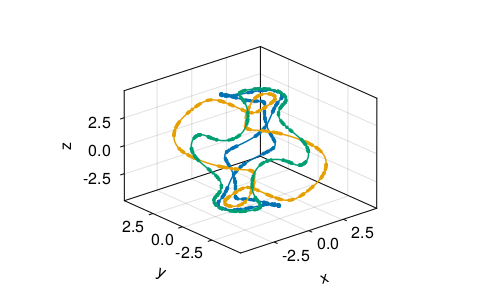

In [66]:
fig = Figure()
ax = Axis3(fig[1,1])
for (k, A) in attractors
    x, y, z = columns(A)
    scatter!(ax, x, y, z; markersize = 5)
    X, t = trajectory(thomas, 50.0, A[1])
    xt, yt, zt = columns(X)
    lines!(ax, xt, yt, zt)
end
fig

## `AttractorsViaFeaturizing`

This is an alternative way to find "attractors", which works as follows:
1. Initial conditions are evolved to generate trajectories
2. Trajectories are mapped into "features": descriptive numbers of the trajectories that hopefully characterize different attractors differently. E.g., mean and std. of the first two  variables for a four-dimensional feature.
3. Features are grouped with one of the three following ways:
   1. `GroupViaClustering`
   2. `GroupViaNearestFeature`
   3. `GroupViaHistogram`
4. The generated groups then correspond to unique "attractors".



It is not obvious what features would be good to separate the attractors of the previous example, which is why we recommend the recurrences method as the better method to use in those kinds of systems.

In any case, here we have estimated in advance a featurizer that works well:

In [ ]:
using Statistics: mean, std

function featurizer(A, t) # take in attractor and time vector
    x, y, z = columns(A)
    mx = mean(x)
    sx = std(y)
    cz = std(y .- z)
    return SVector(mx, sx, cz) # return feature
end

grouping_config = GroupViaClustering()

We also choose how to group features together. For simplicity, we will use a black box clustering algorithm

In [ ]:
grouping_config = GroupViaClustering();

We now put everything together in `AttractorsViaFeaturizin` and get the fractions of the basins of attraction:

In [ ]:
mapperf = AttractorsViaFeaturizing(
    thomas, featurizer, grouping_config; 
    Ttr = 100.0, T = 50.0, Δt = 0.1
)

fs = basins_fractions(
    mapperf, sampler; 
    show_progress = false
)

## Continuation of attractors and their basins fractions

_Note: here we are talking about continuation of arbitrary attractors and their basins of attraction. This is NOT the traditional linearized bifurcation analysis and continuation of fixed points. To learn more about the differences, read our [comparison section online](https://juliadynamics.github.io/Attractors.jl/dev/continuation/#A-new-kind-of-continuation)!_

Continuation in the context of Attractors.jl is done using the `continuation` function, so let's read its documentation string.

_Currently documentation display in VSCode Jupyter
is bugged... So see it [online instead](https://juliadynamics.github.io/Attractors.jl/dev/continuation/#Continuation-API)._

Alright, let's now focus on one of two continuation methods, the recurrences based one. Applying this method to the Thomas system we used previously is not interesting, because due to symmetry the fractions are constantly 1/3. Instead, let's try to find, and continue, the attractors and the basins of attraction of the model from:

> Synthetic multistability in mammalian cells, Zhu et al., Science 375 (2022), DOI: 10.1126/science.abg9765
>
> _An important goal for synthetic biology is to establish control systems that allow the direction of cells into multiple stable states, much like biological signaling systems do during organismal development. Zhu et al. devised a system that allows such control through designed zinc finger transcription factors that interact with one another through homo- and heterodimerization and can be regulated by small molecules that control dimerization and stability of the transcription factors (see the Perspective by Kunze and Khalil). Mathematical modeling allowed computational prediction of the system’s behavior, and introduction of three designed transcription factors in cultured mammalian cells allowed direction of the cells into seven distinct, stable states. Understanding such multistability is useful in synthetic biology and can help to determine its roles in development and disease processes._

 

$$
\dot{A_i} = \alpha + \beta \frac{ B_i^n }{ 1 + B_i^n } - A_i, \quad i = 1, \ldots, N, 
$$

with

$$
B_i = \frac{2A_i^2}{ K_d + 4\sum A_i  + \sqrt{ K_d^2 + 8\sum A_i + K_d } }
$$

Here we will use $N=3$ and parameters `α=4, β=20, n=1.5, Kd=80.0`. We are interested in the behavior of the model versions the `Kd` parameter. The state space tesselation will be from 0 to 100 for each dimension, divided into 100 cells.

In [ ]:
# Define dynamical system
function cell_differentiation(N = 3, u0 = rand(N); α=4, β=20, n=1.5, Kd=80.0)
    p = [Kd, α, β, n]
    ds = CoupledODEs(cell_differentiation_rule!, u0, p)
    return ds
end
function cell_differentiation_rule!(du, u, p, t)
    Kd, α, β, n = p
    sum_u = sum(u)
    @inbounds for i ∈ eachindex(du)
        C = (2*u[i]^2) / (Kd + 4*sum_u + sqrt( Kd^2 + 8*sum_u*Kd )  )
        du[i] = α + (β*C^n)/(1+C^n) - u[i]
    end
    return nothing
end

ds = cell_differentiation(3)

Let's create a `AttractorsViaRecurrences`, and check how many attractors are there in the defualt values

In [ ]:
mapper_config = (;mx_chk_safety = Int(1e9))
grid = ntuple(i -> range(0, 100, length=101), 3)

sampler, = statespace_sampler(
    min_bounds = minimum.(grid), max_bounds = maximum.(grid)
)

mapper = AttractorsViaRecurrences(
    ds, grid; mapper_config...
)

fs = basins_fractions(mapper, sampler)
attractors = extract_attractors(mapper)

Great! Since we have the attractor mapper already, the only thing we need to do to continue these attractors accross a parameter range is to initialize a `RecurrencesSeededContinuation` with the mapper, and give it to the `continuation` function!

In [ ]:
rsc = RecurrencesSeededContinuation(mapper; threshold = Inf)

pidx = 1 # index of parameter to change (here Kd)
prange = range(0, 100; length = 101) # parameter range to scan

fractions_curves, attractors_info = continuation(
    rsc, prange, pidx, sampler;
    show_progress = false, samples_per_parameter = 100
)
fractions_curves

The above result is how the fractions of the attractors behave versus the $K_d$ parameter. As you can see, the number of attractors changes as the parameter changes...

To visualize this result, we would have to write some code that loops through the dictionaries and collects the fractions and plots... Attractors.jl has some code that does it already, but we need to do a small hack to load the code:

In [ ]:
include(
    joinpath(pathof(Attractors), "..", "..", "docs", "basins_plotting.jl")
)

In Julia versions 1.9 or later this hack won't be necessary; the code will be available as soon as you use Makie.jl (or its backends).

Aaaanyways, let's now actually plot the results we found:

In [ ]:
# Decide how to plot attractors: go from attractor to real number
attractor_to_real = A -> mean((x[1] + x[2])/2 for x in A)

basins_attractors_curves_plot(fractions_curves, attractors_info, attractor_to_real, prange)

# Exercises - Attractors.jl

## Basins of attraction of the multistable predator prey model

Continue from the exercise of the previous block, where you have defined a `CoupledODE` representing a modified Rozenweig-MacArthur model. Consider the following two parameter values: `r1 = 1, r2 = 2`. For each parameter value, use the `AttractorViaRecurrences` and `basins_of_attraction` to compute, and plot, the basins of attraction. On top of the basins of attraction also scatterplot the returned attractors. 

For this exercise, use the following grid:

```julia
density = 201
xg = range(0, 20; length = density)
yg = range(0, 0.03; length = density)
grid = (xg, yg)
```

and, very importantly, use a non-adaptive integrator when you define your `CoupledODEs`. E.g., do
```julia
using OrdinaryDiffEq: Tsit5
diffeq = (alg = Tsit5(), adaptive = false, dt = 0.05)
ds = CoupledODEs(predator_prey_rule, u0, p; diffeq)
```
This is because in some systems with limit cycles using an adaptive solver makes the solver step size commensurate with the limit cycle period, which leads to incorrect assignment of initial conditions to the limit cycle. To further increase accuracy of the algorithm, increase two of the parameters of `AttractorsViaRecurrences` that set how many cells to count until you declare you have an attractor. Use the following as a mapper:
```julia
mapper = AttractorsViaRecurrences(
    ds, grid; mx_chk_fnd_att = 2000, mx_chk_loc_att = 4000
)
```


The exercise solution is a plot that looks like the one below:

_Hint: If `A` is a `StateSpaceSet` (i.e., an attractor), then you can do `scatter!(ax, (vec(A))` to immediatelly scatterplot the attractor into an axis!_

![makie_ex_fig_1.png](basins_ex_fig_1.png)

## Continuing the basins fractions

Continue from the previous exercise, and now use the `continuation` function to continue attractors and their fractions across the parameter range `r = 1` to `2`. Use the `statespace_sampler` function to generate random initial conditions in the `grid` you defined above. Plot the fractions of basins of attraction versus the parameter range, and the attractor value, using the following function to map attractors to real numbers:
```julia
using Statistics: mean
attractor_to_real = A -> mean((x[1] + x[2])/2 for x in A)
```

The solution of the exercise should be that you have only two attractors and the fractions of their basins are approximately 50% all the time.

This is weird, right? Focus on `r = 1`. In this case, in the first exercise, you found three attractors, all three being fixed points. Can you give a reasonable explanation of this discrepency, and why the third attractor was not found in the continuation case...?

_hint: think of what kind of initial conditions are generated by the random sampling process, or by scanning the grid explicitly_